In [2]:
import dataclasses
import glob
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from skimage import measure

import invrs_opt

from invrs_gym import challenges

I0000 00:00:1698267450.509808       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
# Select the challenge to be solved.
challenge = challenges.photon_extractor()

# Define the loss function; in this case we simply use the default challenge
# loss. Note that the loss function can return auxilliary quantities.
def loss_fn(params):
    response, aux = challenge.component.response(params)
    loss = challenge.loss(response)
    metrics = challenge.metrics(response, params, aux)
    return loss, (response, aux, metrics)

# Get the initial parameters, and initialize the optimizer.
params = challenge.component.init(jax.random.PRNGKey(0))
opt = invrs_opt.density_lbfgsb(beta=4)
state = opt.init(params)

# The photon extractor challenge can be jit-compiled.
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

# Carry out optimization for a fixed number of steps.
loss_values = []
metrics_values = []
for i in range(35):
    t0 = time.time()
    params = opt.params(state)
    (value, (response, aux, metrics)), grad = value_and_grad_fn(params)
    t1 = time.time()
    state = opt.update(grad=grad, value=value, params=params, state=state)
    
    print(f"{i:03} ({t1 - t0:.2f}/{time.time() - t1:.2f}s): loss={value:.3f}")
    loss_values.append(value)
    metrics_values.append(metrics)

000 (110.78/0.10s): loss=-2.766
001 (89.29/0.07s): loss=-11.575
002 (161.55/0.05s): loss=-15.918
003 (118.21/0.10s): loss=-15.459
004 (91.83/0.13s): loss=-19.320
005 (96.08/0.05s): loss=-20.371
006 (127.58/0.10s): loss=-22.488
007 (92.69/0.05s): loss=-22.421
008 (94.05/0.07s): loss=-23.765
009 (91.94/0.10s): loss=-24.743
010 (89.97/0.06s): loss=-25.296
011 (89.97/0.06s): loss=-25.642
012 (89.49/0.07s): loss=-26.091
013 (89.40/0.11s): loss=-26.469
014 (107.06/0.06s): loss=-26.753
015 (91.34/0.09s): loss=-27.300
016 (90.65/0.15s): loss=-27.490
017 (89.92/0.11s): loss=-27.606
018 (88.45/0.07s): loss=-27.811
019 (88.80/0.12s): loss=-28.025
020 (96.34/0.07s): loss=-28.145
021 (93.76/0.09s): loss=-28.238
022 (86.42/0.11s): loss=-28.343
023 (83.05/0.09s): loss=-28.447
024 (84.89/0.10s): loss=-28.705
025 (83.00/0.15s): loss=-28.766
026 (83.48/0.11s): loss=-28.786
027 (85.53/0.14s): loss=-28.801
028 (83.58/0.06s): loss=-28.822
029 (91.21/0.07s): loss=-28.847
030 (103.24/0.08s): loss=-28.860
031

In [ ]:
# Recompute the response, now including the fields.
_, aux_with_fields = challenge.component.response(params, compute_fields=True)

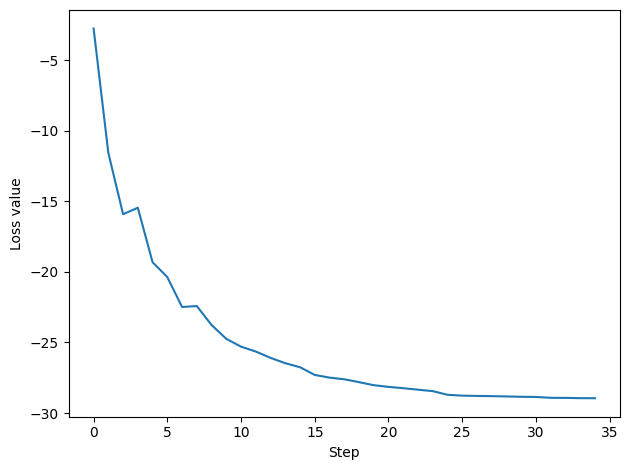

In [13]:
# Plot the loss and efficiency vs. step.
step = onp.arange(len(loss_values))

plt.plot(step, loss_values)
plt.xlabel("Step")
plt.ylabel("Loss value")

plt.tight_layout()

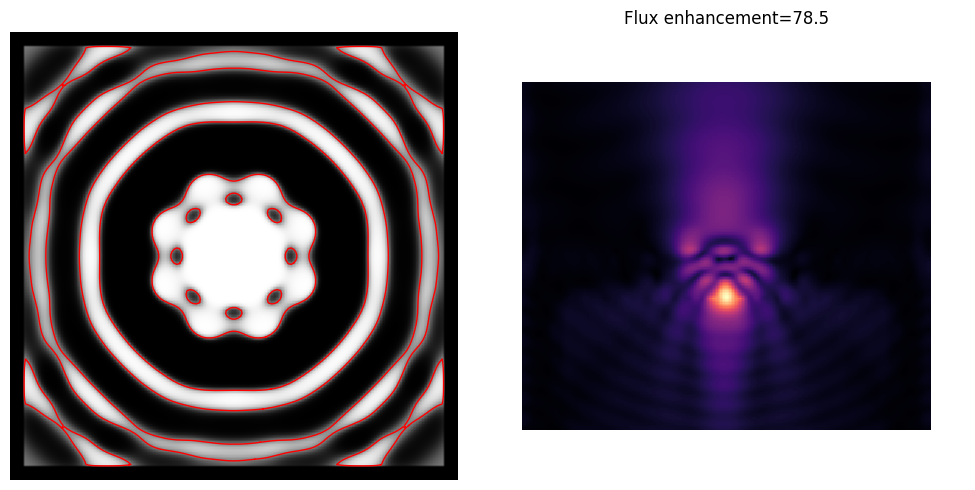

In [27]:
# Plot the optimized density.
plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
density_plot = params.array[60:-60, 60:-60]
im = ax.imshow(density_plot, cmap="gray")
im.set_clim([0, 1])
ax.axis(False)

contours = measure.find_contours(onp.asarray(density_plot))
for c in contours:
    plt.plot(c[:, 1], c[:, 0], "r", lw=1)

plt.subplot(122)
x, y, z = aux_with_fields["field_coordinates"]
ex, ey, ez = aux_with_fields["efield"]
xplot, zplot = jnp.meshgrid(x, z, indexing="ij")
field_plot = jnp.sqrt(jnp.abs(ex)**2 + jnp.abs(ey)**2 + jnp.abs(ez)**2)

ax = plt.subplot(122)
plt.pcolormesh(xplot, zplot, field_plot[:, :, 1], cmap="magma")
ax.axis("equal")
ax.axis("off")
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_title(f"Flux enhancement={metrics['enhancement_flux_mean']:.1f}")

plt.tight_layout()

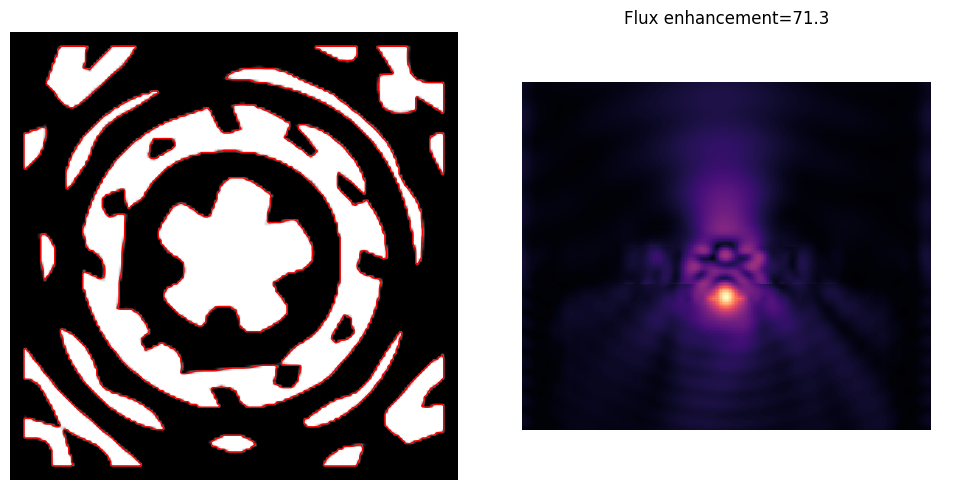

In [26]:
# Load and simulate the reference designs.
fname, = glob.glob("../reference_designs/photon_extractor/*.csv")

plt.figure(figsize=(10, 5))

design = onp.genfromtxt(fname, delimiter=",")
design = onp.pad(design, ((65, 65), (65, 65)))

reference_params = dataclasses.replace(params, array=design)

reference_response, reference_aux = challenge.component.response(reference_params, compute_fields=True)
reference_metrics = challenge.metrics(reference_response, reference_params, reference_aux)

ax = plt.subplot(121)
density_plot = reference_params.array[60:-60, 60:-60]
im = ax.imshow(density_plot, cmap="gray")
im.set_clim([0, 1])
ax.axis(False)

contours = measure.find_contours(onp.asarray(density_plot))
for c in contours:
    plt.plot(c[:, 1], c[:, 0], "r", lw=1)

plt.subplot(122)
x, y, z = reference_aux["field_coordinates"]
ex, ey, ez = reference_aux["efield"]
xplot, zplot = jnp.meshgrid(x, z, indexing="ij")
field_plot = jnp.sqrt(jnp.abs(ex)**2 + jnp.abs(ey)**2 + jnp.abs(ez)**2)

ax = plt.subplot(122)
plt.pcolormesh(xplot, zplot, field_plot[:, :, 1], cmap="magma")
ax.axis("equal")
ax.axis("off")
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_title(f"Flux enhancement={reference_metrics['enhancement_flux_mean']:.1f}")

plt.tight_layout()